## Make Figure Data: Notebook for tasmax, pr seasonal quantile trend maps for all GCMs in GDPCIR paper

* Data prep and save for Figures 3 and 4
* Figures are made in `fig_3-4_tasmax_pr_seasonal_quantile_trends_allmodels.ipynb`


In [1]:
import os

# put this wherever you want
FIGURE_OUTPUT_DIR = "/gcs/impactlab-data/climate/downscaling/qc/kelly_diagnostics/figure3-4/images"#{var}/{kwstr}" 

REPO_ROOT = "../../"
assert "notebooks" in os.listdir(REPO_ROOT)

figure_3_output_file_path = os.path.join(
    FIGURE_OUTPUT_DIR,
    "figure_3_{var}_summer_q{quant}_trend_with_biascorrected_clipped_{model}.png",
)
figure_3diagnostic_output_file_path = os.path.join(
    FIGURE_OUTPUT_DIR,
    "figure_3-4_{var}_{season}_q{quant}_trend_with_biascorrected_downscaled_clipped_{model}.png",
)
figure_3diagnostic_withdownscaled_output_file_path = os.path.join(
    FIGURE_OUTPUT_DIR,
    "figure_3_{var}_{season}_q{quant}_trend_with_biascorrected_downscaledvraw_clipped_{model}.png",
)


figure_a2_output_file_path = os.path.join(
    FIGURE_OUTPUT_DIR,
    "figure_a2_tasmax_summer_q{quant}_trend_diff_linear_{model}.png",
)

fps_yaml_path = os.path.join(
    REPO_ROOT,
    "notebooks/downscaling_pipeline/post_processing_and_delivery/data_paths.yaml",
)


bucket_mapping_oregon_trail = {
    "biascorrected-492e989a": "biascorrected-4a21ed18",
    "clean-b1dbca25": "clean-f1e04ef5",
    "downscaled-288ec5ac": "downscaled-48ec31ab",
    "raw-305d04da": "raw-957d115e",
    "support-c23ff1a3": "support-f8a48a9e",
}

# NEW support BUCKET
BUCKET = 'support-f8a48a9e'
DS_BUCKET = 'downscaled-48ec31ab'


In [2]:
%%capture
try:
    import rhg_compute_tools
except ModuleNotFoundError:
    ! pip install rhg_compute_tools

In [3]:
try:
    import dodola.services
    from dodola.services import xesmf_regrid

except ModuleNotFoundError:
    print("pip install")
    %pip install --no-deps git+https://github.com/ClimateImpactLab/dodola

    from dodola.services import xesmf_regrid

pip install
  Cloning https://github.com/ClimateImpactLab/dodola to /tmp/pip-req-build-hh8gweph
  Running command git clone --filter=blob:none --quiet https://github.com/ClimateImpactLab/dodola /tmp/pip-req-build-hh8gweph
  Resolved https://github.com/ClimateImpactLab/dodola to commit 0c87ec68ffb353aa0fd400c97698f16109323703
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dodola: filename=dodola-0.19.1.dev95+g0c87ec6-py3-none-any.whl size=38706 sha256=579b337977381af701558000990062cdb2c4c322765bf3f1fab1cced438bcb18
  Stored in directory: /tmp/pip-ephem-wheel-cache-eww4naar/wheels/eb/f3/64/7bf41fab62a10d3e4c313f1630b5aa06a86991cab68a10a9c2
Successfully built dodola
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cartopy.crs as ccrs
import dask
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datatree import DataTree
import yaml
from cartopy.feature import NaturalEarthFeature
from rhg_compute_tools import kubernetes as rhgk

import sys
sys.path.insert(1, '../downscaling_pipeline/post_processing_and_delivery/')
import dc6_functions


# Save out intermediate data for figure-making later in notebook

In [5]:
# each 50 workers get 1/2 a 48GiB Node.
# necessary to use half a node b/c of reanalysis.
from dask_gateway import Gateway

gateway = Gateway()
img = os.environ["JUPYTER_IMAGE"]
# with gateway.new_cluster(worker_image=img, scheduler_image=img) as cluster:

cluster = gateway.new_cluster(worker_image=img, scheduler_image=img, profile="giant")
client = cluster.get_client()
# img = "pangeo/pangeo-notebook:2023.04.15"
# client, cluster = rhgk.get_big_cluster(name=img,
#                                        scheduler=img,
#                                        # extra_pip_packages='xarray xclim rhg_compute_tools --no-deps git+https://github.com/ClimateImpactLab/dodola'
#                                       )
# extra_pip_packages='cdsapi'
cluster.scale(100); # used 130 workers to process all pr models

In [6]:
cluster

In [26]:
# cluster.scale(0)
# client.restart()
# del cluster, client

In [7]:
variables = ['tasmax', 'tavg', 'pr']
models = dc6_functions.get_cmip6_models()
institutions = dc6_functions.get_cmip6_institutions()
ensemble_members = dc6_functions.get_cmip6_ensemble_members()



In [8]:
mod = list(models.keys())[0]
fut_scenario = "ssp370"
var = "pr" 

months = [6, 7, 8]
quantiles = [0.01, 0.05, 0.5, 0.95,0.99]

# CODE TO DEAL WITH WET AND DRY DAY THRESHOLDS
wetthresh = False # >= threshval
drythresh = True # 0 < data < threshval
threshval = 10
assert wetthresh + drythresh == 1

In [9]:
with open(fps_yaml_path, "r") as f:
    fps = yaml.load(f, yaml.Loader)

In [10]:

def read_data(model, scenario, variable, step_label, pix, fps=fps, ref=False,chunks="auto"):
        
    if ref:
        if step_label == 'downscaled_delivered':
            # "QPLAD fine reference zarr"
            da = xr.open_zarr(f'gs://support-f8a48a9e/qplad-fine-reference/{variable}/v20220201000555.zarr', 
                                 chunks=chunks)[variable]
        elif step_label == 'biascorrected':
            # "QDM reference zarr"
            da = xr.open_zarr(f'gs://support-f8a48a9e/qdm-reference/{variable}/v20220201000555.zarr', 
                                 chunks=chunks)[variable]
        else:
            raise ValueError
    else:
        da = xr.open_zarr(fps[f'{model}-{variable}'][scenario][step_label], chunks=chunks)[variable]
    
    if pix is not None:
        da = da.isel(lat=pix["lat"], lon=pix["lon"], drop=True)
    if (step_label == "biascorrected") and (variable=="tasmax"):
        # apply the swap to be consistent with downscaling
        da_tasmin = xr.open_zarr(fps[f"{model}-tasmin"][scenario][step_label])["tasmin"]
        if pix is not None:
            da_tasmin = da_tasmin.isel(lat=pix["lat"], lon=pix["lon"], drop=True)
        da = xr.where(da_tasmin > da, da_tasmin, da)
    return da


In [11]:
def cap_precip(ref, hist, fut):
    # compute ref max over training period
    ref_max_pr = ref.sel(time=slice('1994-12-16', '2015-01-15')).max('time').compute()
    # comput hist max over training period
    hist_max_pr = hist.sel(time=slice('1994-12-16', '2015-01-15')).max('time').compute()
    # compute fut max over 21 year period the given date falls in
    max_pr_per_year = (
        xr.concat([hist, fut], dim='time')
        .groupby('time.year')
        .max(dim='time')
        .rolling(year=21, center=True, min_periods=21)
        .max()
        .compute()
    )
    
    # compute the factor making sure not to leave nans around
    factor = (
        (max_pr_per_year.dropna(dim='year', how='all') / hist_max_pr)
    )
    # compute the cap with all this
    cap_values = ref_max_pr * np.maximum(1, factor)
    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        cap_values_expanded = (
            cap_values
            .reindex(year=np.unique(fut.time.dt.year), method='nearest')
            .sel(year=fut.time.dt.year)
            .drop('year')
        )
        
        capped_fut = np.minimum(fut, cap_values_expanded)
          
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        cap_values_expanded_hist = (
            cap_values
            .reindex(year=np.unique(hist.time.dt.year), method='nearest')
            .sel(year=hist.time.dt.year)
            .drop('year')
        )
        
        capped_hist = np.minimum(hist, cap_values_expanded_hist)
        
    return capped_hist, capped_fut

In [12]:
def gcm_pr_q_trend_biascorrected_pix(pix, model, fut_scenario, 
                                  quantile,
                                  fut_period=range(2080, 2100+1), 
                                  hist_period=range(1995, 2014+1), 
                                    ) -> xr.DataArray():
    
    """
    function that loads GCM data at the step `step_label` (raw, bias corrected, downscaled etc) 
    from the URLs yaml file and computes the trend in a particular seasonal quantile of tasmax 
    for `model`, scenario `fut_scenario`, variable `var. Trend is computed between `fut_period` 
    and `hist_period`. Season is defined with `months`. Quantile is defined with `quantile`. 
    
    You can locally, without the dask cluster, test the function with `pix`.
    """
    fut = read_data(model=model, scenario=fut_scenario, variable="pr", 
                    step_label='biascorrected', pix=pix, chunks=None)
    hist = read_data(model=model, scenario='historical', variable="pr",
                     step_label='biascorrected', pix=pix, chunks=None)

    fut = fut.load()
    hist = hist.load()
  
    ref = read_data(variable="pr",step_label='biascorrected', ref=True,
                    pix=pix, chunks=None, model=None, scenario=None)
    ref = ref.load()
    hist, fut = cap_precip(ref, hist, fut)
        
    fut = fut.where(fut.time.dt.year.isin(fut_period), drop=True)
    seadt={}
    for sea,months in zip(["DJF","MAM","JJA","SON"],
                          [[12,1,2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        tst = fut.where(fut.time.dt.month.isin(months), drop=True)
        tst = tst.assign_coords(season=('time', [sea,]*len(tst.time)))
        tst = tst.swap_dims({'time': 'season'})
        seadt[sea] = tst
    fut = xr.concat(seadt.values(),dim="season")
    
    hist = hist.where(hist.time.dt.year.isin(hist_period), drop=True)
    seadt={}
    for sea,months in zip(["DJF","MAM","JJA","SON"],
                          [[12,1,2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        tst = hist.where(hist.time.dt.month.isin(months), drop=True)
        tst = tst.assign_coords(season=('time', [sea,]*len(tst.time)))
        tst = tst.swap_dims({'time': 'season'})
        seadt[sea] = tst
    hist = xr.concat(seadt.values(),dim="season")

    if wetthresh:
        fut = fut.where(fut>=threshval) 
        hist = hist.where(hist>=threshval) 
    elif drythresh:
        fut = fut.where((fut>0) & (fut<threshval)) 
        hist = hist.where((hist>0) & (hist<threshval)) 
        
    fut_q = fut.groupby("season").quantile(q=quantile)
    hist_q = hist.groupby("season").quantile(q=quantile)
    trend = fut_q/hist_q
    
    return trend

def gcm_pr_q_trend_biascorrected(**kwargs): 
    pixs = [{'lat': [x], 'lon': list(range(0, 360))} for x in range(0, 180)]
    futs = client.map(gcm_pr_q_trend_biascorrected_pix, pixs, **kwargs)
    results = client.gather(futs)
    return xr.combine_by_coords(results).pr

In [13]:
def gcm_historical_q(model, step_label, 
                     variable,
                     quantile, 
                     hist_period=range(1995, 2014+1), 
                     pix=None) -> xr.DataArray():
    
    """
    function that loads historical GCM data at the step `step_label` (raw, bias corrected, downscaled etc) 
    from the URLs yaml file and computes the seasonal quantiles
    for `model`, scenario `fut_scenario`, variable `variable`. 
    Quantiles are defined with `quantile`. 
    
    You can locally, without the dask cluster, test the function with `pix`.
    """
    hist = read_data(model=model, scenario='historical', variable=variable, 
                     step_label=step_label, pix=pix)
    
    hist = hist.where(hist.time.dt.year.isin(hist_period), drop=True)
    seadt={}
    for sea,months in zip(["DJF","MAM","JJA","SON"],
                          [[12,1,2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        tst = hist.where(hist.time.dt.month.isin(months), drop=True)
        tst = tst.assign_coords(season=('time', [sea,]*len(tst.time)))
        tst = tst.swap_dims({'time': 'season'})
        seadt[sea] = tst
    hist = xr.concat(seadt.values(),dim="season")
    
    if pix is not None:
        hist = hist.load()
    else:
        # move chunks to space to take temporal quantile
        hist = hist.chunk({'season': -1, 'lat': 360, 'lon': 360})

    if wetthresh:
        hist = hist.where(hist>=threshval) 
    elif drythresh:
        hist = hist.where((hist>0) & (hist<threshval)) 
    
    hist_q = hist.groupby("season").quantile(q=quantile)
    
    return hist_q

def ref_q(variable,
          quantile, 
          period=range(1995, 2014+1),
          pix=None) -> xr.DataArray():

    """
    function that loads variable reanalysis data and computes the `quantile` of the 
    time series subset defined by `period` (years) and `months` (seasonality). 
    
    You can locally, without the dask cluster, test the function with `pix`.
    """
    
    ref_da = read_data(variable=variable, ref=True, step_label='downscaled_delivered', 
                       pix=pix, model=None, scenario=None)
    
    ref_da = ref_da.where(ref_da.time.dt.year.isin(period), drop=True)
    # ref_da = ref_da.where(ref_da.time.dt.month.isin(months), drop=True)
    seadt={}
    for sea,months in zip(["DJF","MAM","JJA","SON"],
                          [[12,1,2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        tst = ref_da.where(ref_da.time.dt.month.isin(months), drop=True)
        tst = tst.assign_coords(season=('time', [sea,]*len(tst.time)))
        tst = tst.swap_dims({'time': 'season'})
        seadt[sea] = tst
    ref_da = xr.concat(seadt.values(),dim="season")
    
    if pix is not None:
        ref_da = ref_da.load()
    else:
        # move chunks to space to take temporal quantile
        ref_da = ref_da.chunk({'season':-1, 'lat':360, 'lon':360})
        
    if wetthresh:
        ref_da = ref_da.where(ref_da>=threshval) # @@@@
    elif drythresh:
        ref_da = ref_da.where((ref_da>0) & (ref_da<threshval)) # @@@@

    ref_q = ref_da.groupby("season").quantile(q=quantile)#, dim='time')
    return ref_q

In [14]:

def gcm_q_trend(
    model,
    scenario,
    variable,
    step_label,
    # months,
    quantile,
    fut_period=range(2080, 2100 + 1),
    hist_period=range(1995, 2014 + 1),
    pix=None,
) -> xr.DataArray:
    """
    calculate period difference in a seasonal quantile

    function that loads GCM data at the step `step_label` (raw, bias corrected,
    downscaled etc) from the URLs yaml file and computes the trend in a particular
    seasonal quantile of tasmax for `model`, scenario `fut_scenario`, variable `var.
    Trend is computed between `fut_period` and `hist_period`. Season is defined with
    `months`. Quantiles to compute are defined with `quantile`, a scalar or list.

    You can locally, without the dask cluster, test the function with `pix`.
    """

    # read data, subset time series for fut
    fut = read_data(model=model, scenario=scenario, variable=variable,
                               step_label=step_label, pix=pix)
        
    fut = fut.where(fut.time.dt.year.isin(fut_period), drop=True)
    seadt={}
    for sea,months in zip(["DJF","MAM","JJA","SON"],
                          [[12,1,2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        tst = fut.where(fut.time.dt.month.isin(months), drop=True)
        tst = tst.assign_coords(season=('time', [sea,]*len(tst.time)))
        tst = tst.swap_dims({'time': 'season'})
        seadt[sea] = tst
    fut = xr.concat(seadt.values(),dim="season")

    # same for hist
    hist = read_data(model=model, scenario="historical", variable=variable,
                     step_label=step_label, pix=pix)
    hist = hist.where(hist.time.dt.year.isin(hist_period), drop=True)
    seadt={}
    for sea,months in zip(["DJF","MAM","JJA","SON"],
                          [[12,1,2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        tst = hist.where(hist.time.dt.month.isin(months), drop=True)
        tst = tst.assign_coords(season=('time', [sea,]*len(tst.time)))
        tst = tst.swap_dims({'time': 'season'})
        seadt[sea] = tst
    hist = xr.concat(seadt.values(),dim="season")

    # if took only one pixel, load
    if pix is not None:
        fut = fut.load()
        hist = hist.load()
    else:
        # move chunks to space to take temporal quantile
        fut = fut.chunk({"season": -1, "lat": 360, "lon": 360})
        hist = hist.chunk({"season": -1, "lat": 360, "lon": 360})

    if variable == "pr":
        if wetthresh:
            fut = fut.where(fut>=threshval) # @@@@
            hist = hist.where(hist>=threshval) # @@@@
        elif drythresh:
            fut = fut.where((fut>0) & (fut<threshval)) # @@@@
            hist = hist.where((hist>0) & (hist<threshval)) # @@@@

    fut_q = fut.groupby("season").quantile(q=quantile)
    hist_q = hist.groupby("season").quantile(q=quantile)
    if variable == "pr":
        trend = fut_q/hist_q
    else:
        trend = fut_q - hist_q

    return trend

def regrid_to_coarse_resolution(da):
    domain_ds = xr.open_zarr("gs://support-f8a48a9e/domain.1x1.zarr", chunks=None)
    da = xesmf_regrid(
        x=xr.Dataset({"da": da}),
        domain=domain_ds,
        method="nearest_s2d",
        astype=np.float32,
        add_cyclic=None,
        keep_attrs=True,
    )["da"]
    return da


def regrid_to_downscaled_resolution(da):
    """
    regrid a lat/lon dataarray to the downscaling resolution using dodola's `xesmf_regrid`.
    """
    domain_ds = xr.open_zarr("gs://support-f8a48a9e/domain.0p25x0p25.zarr", chunks=None)
    da = xesmf_regrid(
        x=xr.Dataset({"da": da}),
        domain=domain_ds,
        method="nearest_s2d",
        astype=np.float32,
        add_cyclic=None,
        keep_attrs=True,
    )["da"]
    return da

def cyclic_lon(da):
    """
    [0, 360] - > [-180, 180]
    """
    return da.assign_coords(
        {"lon": xr.where(da.lon > 180, da.lon - 360, da.lon)}
    ).sortby("lon")

def compute_trends(model, scenario, variable, 
                   # months, 
                   quantile):
    
    print("biascorrected_trend")
    if variable=="pr":
        biascorrected_trend = gcm_pr_q_trend_biascorrected(model=model, 
                                                           fut_scenario=fut_scenario,
                                                          quantile=quantile)
    else:
        biascorrected_trend = gcm_q_trend(
            model=model, scenario=scenario, variable=variable, step_label="biascorrected",
            # months=months, 
            quantile=quantile
        ).compute()

    biascorrected_trend = cyclic_lon(biascorrected_trend)
    biascorrected_trend.values = np.ascontiguousarray(biascorrected_trend.values)
    biascorrected_fine_trend = regrid_to_downscaled_resolution(biascorrected_trend)
    
    print("downscaled_trend")
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        downscaled_trend = gcm_q_trend(
            model=model,
            scenario=scenario,
            variable=variable,
            step_label="downscaled_delivered",
            # months=months, 
            quantile=quantile
        ).compute()
    
    print("raw_cleaned_trend")
    raw_cleaned_trend = gcm_q_trend(
        model=model,
        scenario=scenario,
        variable=variable,
        step_label="clean",
        # months=months, 
        quantile=quantile
    ).compute()

    print("regridding and cyclic lons")
    raw_cleaned_trend = cyclic_lon(raw_cleaned_trend)
    raw_cleaned_trend.values = np.ascontiguousarray(raw_cleaned_trend.values)
    
    raw_cleaned_trend_regridded_coarse = regrid_to_coarse_resolution(raw_cleaned_trend)
    raw_cleaned_trend_regridded_coarse.values = np.ascontiguousarray(raw_cleaned_trend_regridded_coarse.values)
    raw_cleaned_trend_regridded_fine = regrid_to_downscaled_resolution(
        raw_cleaned_trend_regridded_coarse
    )
    
    raw_cleaned_trend_regridded_direct = regrid_to_downscaled_resolution(raw_cleaned_trend)
    if variable == "pr":
        diff_downscaled_regriddedraw = downscaled_trend / raw_cleaned_trend_regridded_fine
        diff_downscaled_biascorrected = downscaled_trend / biascorrected_fine_trend
    
        diff_biascorrected_regriddedraw = (
            biascorrected_trend / raw_cleaned_trend_regridded_coarse
        )
    else:
        diff_downscaled_regriddedraw = downscaled_trend - raw_cleaned_trend_regridded_fine
        diff_downscaled_biascorrected = downscaled_trend - biascorrected_fine_trend
    
        diff_biascorrected_regriddedraw = (
            biascorrected_trend - raw_cleaned_trend_regridded_coarse
        )
    
    print("historical quantile")
    raw_cleaned_historical_q = gcm_historical_q(model=model,
                                                variable=variable,
                                                quantile=quantile, 
                                                step_label='clean').compute()
    raw_cleaned_historical_q_regridfine = regrid_to_downscaled_resolution(cyclic_lon(raw_cleaned_historical_q))

    all_plot_pieces = [
        raw_cleaned_trend,
        diff_biascorrected_regriddedraw,
        diff_downscaled_biascorrected, # <--- coming out all nans @@@@
        diff_downscaled_regriddedraw,  # <--- coming out all nans @@@@
        raw_cleaned_trend_regridded_coarse, # use this for averaging across GCMs
        raw_cleaned_historical_q, # use this for precip Fig (fig4) panel 2
        raw_cleaned_historical_q_regridfine, # use this in case comparing historical q to ref q
    ]
    
    return all_plot_pieces

In [15]:
# only need to do this once (not per GCM)
def get_reference_quantile(variable, quantile):
    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        rq = ref_q(variable,quantile)
        
    rq = rq.compute()
    rq = cyclic_lon(rq)
    return rq

In [16]:
var,quantiles

('pr', [0.01, 0.05, 0.5, 0.95, 0.99])

In [17]:
threshstr=""
if wetthresh:
    threshstr=f"wetthresh{threshval}_"
elif drythresh:
    threshstr=f"drythresh{threshval}_"
threshstr

'drythresh10_'

### Compute the reference seasonal quantiles and save to disk

In [18]:
SCRATCH = "/gcs/impactlab-data/climate/downscaling/qc/kelly_diagnostics/figure3-4"#impactlab-data-scratch"
SAVEDIR = f"{SCRATCH}"#/gdpcir-diagnostics/figure3-4/"

if var=="pr":
    reference_quantile = get_reference_quantile(variable=var,
                                                quantile=quantiles)



    attrs = {
        "Created by": "Kelly McCusker <kmccusker@rhg.com",
        "Date created": "May 9, 2023",
        "Description": (
            "Figure 4, panel 1 (as submitted, ERA5 reference quantiles). "+\
            f"This is seasonal daily {var} quantile 1995-2014 (0.25deg resolution)."
        )
    }
    reference_quantile.attrs.update(attrs)
    reference_quantile.to_netcdf(f"{SAVEDIR}/figure_3-4_ERA5_{var}_allseason_{threshstr}quantiles_fine_reference.nc", 
                            encoding={var: {"zlib": True}})
    print("saved")

saved


In [19]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://notebooks.cilresearch.org/services/dask-gateway/clusters/jhub.f212717dac144149a4f611caeaf20345/status,


## test wrapper function. 

In [ ]:

all_pieces = compute_trends(model=mod, scenario=fut_scenario, variable=var, 
                            # months=months,
                            quantile=quantiles
                           )

In [ ]:

all_pieces

In [21]:
for it in all_pieces:
    print(it.nbytes/(1024)**3)
    
        # raw_cleaned_trend,
        # diff_biascorrected_regriddedraw,
        # diff_downscaled_biascorrected,
        # diff_downscaled_regriddedraw,
        # raw_cleaned_trend_regridded_coarse, # use this for averaging across GCMs
        # raw_cleaned_historical_q, # use this for precip Fig panel 2
        # raw_cleaned_historical_q_regridfine, # use this in case comparing historical q to ref q


0.00762939453125
0.009655952453613281
0.1544952392578125
0.1544952392578125
0.004827976226806641
0.00762939453125
0.07724761962890625


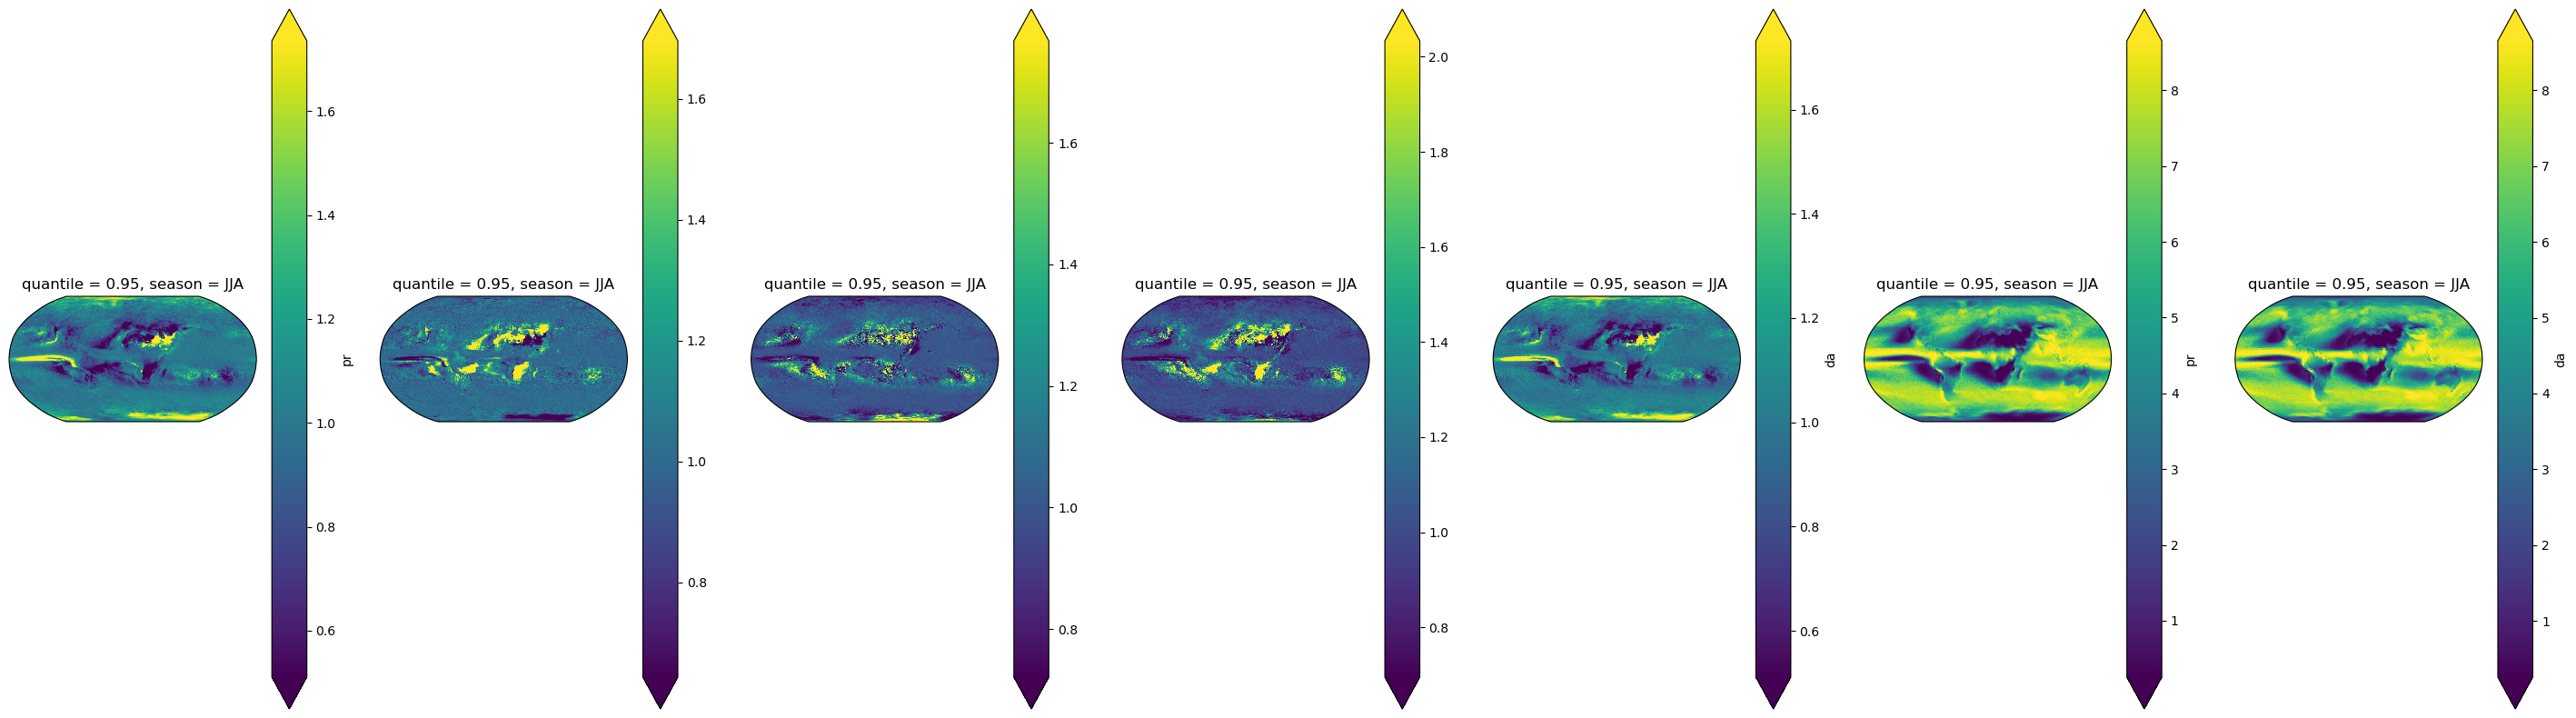

In [22]:
fig, axes = plt.subplots(ncols=len(all_pieces), nrows=1, figsize=(36, 10), subplot_kw={'projection': ccrs.Robinson()})
coastline_feature = NaturalEarthFeature('physical', 'coastline', '50m',
                                       edgecolor='black', facecolor='none')
for i,_ in enumerate(all_pieces):
    ax = axes[i]
    im = all_pieces[i].sel(quantile=0.95,season="JJA").plot(add_colorbar=True, ax=ax, 
                                                           transform=ccrs.PlateCarree(), robust=True,
                            # cbar_kwargs=dict(fraction=0.046, pad=0.04,orientation='vertical', 
                            #                  extend='both', label=labels[i]), 
                                                          )
                            # **kwargs_list[i])


### Loop through all GCMs and compute the summary stats

In [24]:
print(models.keys())

dict_keys(['BCC-CSM2-MR', 'FGOALS-g3', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'INM-CM4-8', 'INM-CM5-0', 'MIROC-ES2L', 'MIROC6', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-ESM4', 'GFDL-CM4', 'NESM3', 'MPI-ESM1-2-HR', 'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CanESM5', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR'])


In [ ]:
allmods = []
modsdone = []
for mod in models:
    print(mod)
    # this takes about 2 mins per model with 60 big workers, 1:20 with 100 workers
    if fut_scenario in models[mod]:
        allmods.append(compute_trends(model=mod, scenario=fut_scenario, variable=var, 
                                      # months=months,
                                      quantile=quantiles))
        modsdone.append(mod)
    else: print("skipping..")
        
print("done")
# TODO silence the large chunk warnings
# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     ...     array[indexer]

# TODO change to C_CONTIGUOUS on all arrays that get regridded to fix that warning


In [38]:
len(allmods)

# this took 33 mins for 20 models tasmax with 100 workers
# this took longer for 20 models pr with 120 workers, tho it wasn't timed properly

20

### Reorganize the intermediate outputs: Compile the metrics at different stages for all GCMs

In [40]:
rawcln = {}
rawclncoarse = []
diffbcregridraw = []
diffdnscbc = []
diffdnregridraw = []

rawclnhist = {}
rawclnhistrg = []

for ii,pieces in enumerate(allmods):
        
    rawcln[modsdone[ii]] = pieces[0]       # raw_cleaned_trend, (different grids)
    rawclncoarse.append(pieces[4])    # raw cleaned regridded to coarse
    diffbcregridraw.append(pieces[1]) # diff_biascorrected_regriddedraw
    diffdnscbc.append(pieces[2])      # diff_downscaled_biascorrected
    diffdnregridraw.append(pieces[3]) # diff downscaled v regridded raw
        
    rawclnhist[modsdone[ii]] = pieces[5]  # raw cleaned historical quantile (different grids)
    rawclnhistrg.append(pieces[6])      # raw cleaned historical quantile fine
    
    
    
rawclean_dt = DataTree.from_dict(rawcln)
diffbcrgraw_ds = xr.concat(diffbcregridraw, dim=pd.Index(modsdone, name="model")).to_dataset(name=var)
diffdnscbc_ds = xr.concat(diffdnscbc, dim=pd.Index(modsdone, name="model")).to_dataset(name=var)
diffdnrgraw_ds = xr.concat(diffdnregridraw, dim=pd.Index(modsdone, name="model")).to_dataset(name=var)
rawclncoarse_ds = xr.concat(rawclncoarse, dim=pd.Index(modsdone, name="model")).to_dataset(name=var)

rawcleanhist_dt = DataTree.from_dict(rawclnhist)
rawclnhistrg_ds = xr.concat(rawclnhistrg,dim=pd.Index(modsdone, name="model")).to_dataset(name=var)


### Save intermediate data for the figures

In [41]:
# SCRATCH = "/gcs/impactlab-data-scratch"
# SAVEDIR = f"{SCRATCH}/gdpcir-diagnostics/figure3-4/"
SCRATCH = SCRATCH = "/gcs/impactlab-data/climate/downscaling/qc/kelly_diagnostics/figure3-4"#impactlab-data-scratch"
SAVEDIR = f"{SCRATCH}"#/gdpcir-diagnostics/figure3-4/"


In [43]:
created = "July 11, 2023" #"May 25, 2023"

In [44]:
# Save these outputs for later
attrs = {
    "Created by": "Kelly McCusker <kmccusker@rhg.com",
    "Date created": created,
    "Description": (
        "Figure 3, panel 2 (as submitted) for all GCMs. "+\
        "This is the difference in: seasonal daily tasmax quantile change 2080-2100 "+\
        "relative to 1995-2015 at the bias corrected step and the "+\
        "quantile changes at the raw cleaned step (1deg resolution)."
    )
}
diffbcrgraw_ds.attrs.update(attrs)
diffbcrgraw_ds.to_netcdf(f"{SAVEDIR}/figure_3-4_{fut_scenario}_{var}_allseason_{threshstr}quantiles_trends_biascorrected_v_cleaned_allgcms.nc", 
                        encoding={var: {"zlib": True}})


attrs = {
    "Created by": "Kelly McCusker <kmccusker@rhg.com",
    "Date created": created,
    "Description": (
        "Figure 3, not in panels (as submitted) for all GCMs. "+\
        "This is the difference in: seasonal daily tasmax quantile change 2080-2100 "+\
        "relative to 1995-2015 at the downscaled step and the "+\
        "quantile changes at the bias corrected step (0.25deg resolution)."
    )
}
diffdnscbc_ds.attrs.update(attrs)
diffdnscbc_ds.to_netcdf(f"{SAVEDIR}/figure_3-4_{fut_scenario}_{var}_allseason_{threshstr}quantiles_trends_downscaled_v_biascorrected_allgcms.nc", 
                        encoding={var: {"zlib": True}})


attrs = {
    "Created by": "Kelly McCusker <kmccusker@rhg.com",
    "Date created": created,
    "Description": (
        "Figure 3, not in panels (as submitted) for all GCMs. "+\
        "This is the difference in: seasonal daily tasmax quantile change 2080-2100 "+\
        "relative to 1995-2015 at the downscaled step and the "+\
        "quantile changes at the raw cleaned step (0.25deg resolution)."
    )
}
diffdnrgraw_ds.attrs.update(attrs)
diffdnrgraw_ds.to_netcdf(f"{SAVEDIR}/figure_3-4_{fut_scenario}_{var}_allseason_{threshstr}quantiles_trends_downscaled_v_cleaned_allgcms.nc", 
                        encoding={var: {"zlib": True}})


attrs = {
    "Created by": "Kelly McCusker <kmccusker@rhg.com",
    "Date created": created,
    "Description": (
        "Figure 3, not in panels (as submitted) for all GCMs. "+\
        "This is the seasonal daily tasmax quantile change 2080-2100 "+\
        "relative to 1995-2015 at the raw cleaned step regridded to 1deg resolution."
    )
}
rawclncoarse_ds.attrs.update(attrs)
rawclncoarse_ds.to_netcdf(f"{SAVEDIR}/figure_3_{fut_scenario}_{var}_allseason_{threshstr}quantiles_trends_raw_cleaned_coarse_allgcms.nc", 
                        encoding={var: {"zlib": True}})

In [46]:
attrs = {
    "Created by": "Kelly McCusker <kmccusker@rhg.com",
    "Date created": created,
    "Description": (
        "Figure 3-4, panel 2 for precip, not in tasmax fig (as submitted) for all GCMs. "+\
        "This is the seasonal daily tasmax quantile in the historical sim "+\
        " years 1995-2015 at the raw cleaned step regridded to fine (0.25degree resolution)."
    )
}
rawclnhistrg_ds.attrs.update(attrs)
rawclnhistrg_ds.to_netcdf(f"{SAVEDIR}/figure_3-4_historical_{var}_allseason_{threshstr}quantiles_raw_cleaned_fine_allgcms.nc", 
                        encoding={var: {"zlib": True}})

In [47]:
rawcleanhist_dt = rawcleanhist_dt.compute()

In [48]:
rawclean_dt = rawclean_dt.compute()

In [49]:
# TODO ADD attributes to the datatrees
# the datatrees take awhile to save
print(f"Size of data in tree = {rawclean_dt.nbytes / 1e9 :.2f} GB")
rawclean_dt.to_zarr(f"{SAVEDIR}/figure_3-4_{fut_scenario}_{var}_allseason_{threshstr}quantiles_trends_rawcleaned_allgcms.zarr")

Size of data in tree = 0.15 GB


In [50]:
f"{SAVEDIR}/figure_3-4_{fut_scenario}_{var}_allseason_{threshstr}quantiles_trends_rawcleaned_allgcms.zarr"

'/gcs/impactlab-data/climate/downscaling/qc/kelly_diagnostics/figure3-4/figure_3-4_ssp370_pr_allseason_drythresh10_quantiles_trends_rawcleaned_allgcms.zarr'

In [51]:
print(f"Size of data in tree = {rawcleanhist_dt.nbytes / 1e9 :.2f} GB")
rawcleanhist_dt.to_zarr(f"{SAVEDIR}/figure_3-4_historical_{var}_allseason_{threshstr}quantiles_rawcleaned_allgcms.zarr")


print("saved all")

Size of data in tree = 0.15 GB
saved all


In [ ]:
cluster.scale(0)
# client.restart()
# del cluster, client